In [10]:
%run data_preprocessing.ipynb

# Load data and vector vocabulary

In [6]:
# load vocabulary
fasttext_300d_2m_model = 'crawl-300d-2M.vec'
# time to load: 2min 41s - limit=500000
model = KeyedVectors.load_word2vec_format(fasttext_300d_2m_model, limit=500000)

In [217]:
# load data and combine train test
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df], axis = 0)

In [218]:
# run data preprocessing
prepr_df = data_preprocessing(df, model, create_embedding=True)


100%|██████████| 300/300 [00:02<00:00, 100.41it/s]

In [220]:
# drop some columns
prepr_df.drop(columns=['mean_vector_text', 'main_keyword', 'additional_keyword', 'text'], inplace = True)

# Add embedding features

In [221]:
tr = pd.read_csv('use_train.csv')
tt = pd.read_csv('use_test.csv')
df_embed = pd.concat([tr, tt], axis = 0)
print(df_embed.shape[0] == prepr_df.shape[0])
prepr_df['embedding'] = df_embed['vector_repr']

True


In [222]:
def cast_to_ast(x):
    try:
        return ast.literal_eval(x)
    except:
        print('exception')
        return [0 for i in range(512)]
    
prepr_df['embedding'] = prepr_df['embedding'].apply(cast_to_ast)

In [223]:
f_name = 'f_'
i = 0
for i in tqdm(range(512)):
    prepr_df[f_name + str(i)] = [x[i] for x in prepr_df['embedding']]


100%|██████████| 512/512 [00:03<00:00, 142.82it/s]

In [225]:
# drop some columns
# prepr_df.drop(columns = ['location', 'text', 'copy_text', 'embedding'], inplace = True)
prepr_df.drop(columns = ['location', 'embedding'], inplace = True)

In [226]:
# fill na
prepr_df['keyword'] = prepr_df['keyword'].fillna('Not given')
# prepr_df['location'] = prepr_df['location'].fillna('Not given')

In [239]:
prepr_df

,id,keyword,n_words,n_small_words,mean_len,std_len,n_hashtag,is_question,n_punctuation,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29,v_30,v_31,v_32,v_33,v_34,v_35,v_36,v_37,v_38,v_39,v_40,...,f_464,f_465,f_466,f_467,f_468,f_469,f_470,f_471,f_472,f_473,f_474,f_475,f_476,f_477,f_478,f_479,f_480,f_481,f_482,f_483,f_484,f_485,f_486,f_487,f_488,f_489,f_490,f_491,f_492,f_493,f_494,f_495,f_496,f_497,f_498,f_499,f_500,f_501,f_502,f_503,f_504,f_505,f_506,f_507,f_508,f_509,f_510,f_511,target,split
0,1,Not given,11,8,4.727273,2.135880,1,0,0,-0.082518,-0.019764,-0.079055,-0.009618,-0.015791,-0.036991,-0.043109,-0.086055,0.012845,-0.120664,0.178000,0.294264,-0.037155,-0.013082,-0.067800,-0.024900,0.020464,0.030536,-0.063364,-0.028264,-0.105527,0.031018,0.046491,-0.110200,0.015036,-0.003336,-0.059145,0.018118,0.039873,-0.039582,0.107564,0.126536,0.039336,-0.114791,-0.047845,-0.168755,0.100209,-0.034927,0.005773,0.097436,0.004673,...,-0.062698,-0.001949,0.067970,-0.057371,-0.011293,0.020889,0.029599,0.047144,-0.007127,-0.024195,-0.064229,-0.064512,-0.058666,-0.057128,-0.027105,0.036416,0.053238,-0.045460,-0.006638,0.006142,0.042634,-0.008649,-0.054054,-0.008237,0.074524,0.041343,-0.022508,-0.012185,0.019042,0.068178,0.037821,0.039905,0.035601,-0.025811,-0.044349,-0.037496,0.007533,-0.015699,0.027534,0.015321,-0.012952,0.030849,0.062661,0.053085,0.061110,-0.037655,-0.069413,-0.086716,1.0,train
1,4,Not given,4,2,5.000000,1.000000,0,0,0,-0.019550,-0.134550,-0.249750,-0.013575,-0.176575,-0.021675,-0.145850,-0.013000,0.101775,0.152925,-0.083100,0.224375,-0.001575,-0.056550,-0.030150,-0.152275,0.018300,0.131425,0.164025,-0.164825,-0.041675,-0.065300,0.110300,-0.169425,0.042150,0.015625,0.130350,-0.048825,0.012675,-0.167175,-0.058325,-0.023175,0.000650,-0.057625,0.028475,-0.048525,-0.127125,0.081975,-0.067100,0.153750,0.130750,...,-0.041651,0.031001,0.050589,0.046076,-0.050851,-0.035632,0.050940,0.017945,-0.063554,0.016243,-0.014849,0.039269,0.060681,-0.008266,0.028809,0.051321,0.011021,-0.016379,0.039486,0.060842,-0.097047,0.029250,0.007841,-0.053202,0.050275,0.026464,0.051383,0.043740,0.001092,-0.007018,0.014074,-0.077357,-0.006298,-0.025396,-0.003725,0.017933,-0.046730,0.071481,0.050698,0.030433,-0.011743,-0.049358,-0.073827,-0.026271,0.039067,-0.004579,-0.021209,0.002904,1.0,train
2,5,Not given,16,12,6.062500,2.105610,0,0,0,-0.001688,-0.124981,-0.108687,0.066594,-0.114850,0.085325,-0.159413,0.030725,0.200963,-0.107875,-0.037381,0.215281,0.003344,-0.037806,-0.032819,-0.027175,0.093181,0.023300,0.088406,-0.032881,-0.100681,-0.066662,0.093150,-0.120637,0.036456,-0.041244,0.037631,-0.055387,-0.032200,0.026131,0.055994,-0.079569,0.035687,0.006994,0.008244,0.005713,-0.051238,-0.037606,-0.060444,0.008094,0.094319,...,-0.035153,-0.007303,0.018565,0.035466,0.034791,-0.036482,-0.027327,0.057390,-0.033338,0.040808,0.031893,0.035950,0.028445,-0.072875,-0.069697,0.031297,0.035501,-0.038850,0.028094,-0.033274,-0.028026,-0.033415,0.069154,0.071937,0.001830,0.043931,-0.062386,0.060027,0.008409,0.060500,-0.077309,0.076797,0.026090,-0.051016,0.036185,-0.025865,0.030850,-0.058019,0.079306,-0.070737,0.057787,0.054154,0.051789,0.048429,0.036983,-0.054150,0.072240,0.057898,1.0,train
3,6,Not given,6,6,8.000000,1.732051,1,0,0,0.065483,0.022750,-0.096167,-0.054600,-0.132000,-0.056900,-0.251183,0.194083,0.144967,-0.059917,-0.140617,0.434117,0.015817,0.045333,-0.007600,-0.049717,-0.102833,-0.078583,0.199150,-0.153300,-0.114300,0.031217,0.156717,-0.129933,-0.033100,-0.033483,0.167467,-0.051467,-0.040100,-0.016567,0.136433,-0.010667,0.039750,0.069683,0.152383,0.052533,-0.029617,0.022567,-0.043133,0.156400,0.148450,...,-0.076625,0.014285,0.061766,0.027970,-0.051454,-0.063642,-0.014916,0.059471,-0.067116,0.055581,0.022961,-0.063083,-0.006164,-0.028467,-0.037813,-0.020989,0.055992,-0.043141,0.025980,-0.009416,0.024523,-0.059966,-0.048265,-0.024873,0.056946,-0.053845,-0.004283,0.07473

# Create train, val, test datasets

In [237]:
from sklearn.model_selection import train_test_split

In [238]:
# move 'y' and 'split' to the end
y_index = list(prepr_df.columns).index('target')
col = prepr_df.columns
new_columns = list(col[:y_index]) + list(col[y_index+2:]) + list(col[y_index:y_index+2])
prepr_df = prepr_df[new_columns]

In [240]:
test = prepr_df[prepr_df['split'] == 'test']
train = prepr_df[prepr_df['split'] == 'train']
train.drop(columns = ['split'], inplace = True)
test.drop(columns = ['split'], inplace = True)
X_train = train[train.columns[:-1]]
y_train = train[['target']]
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
x_test = test[test.columns[:-1]]

In [244]:
# x_train.drop(columns = ['id', 'target', 'split'], inplace = True)
# x_val.drop(columns = ['id', 'target', 'split'], inplace = True)
# x_test.drop(columns = ['id', 'target', 'split'], inplace = True)
x_train.drop(columns = ['id'], inplace = True)
x_val.drop(columns = ['id'], inplace = True)
x_test.drop(columns = ['id'], inplace = True)

In [249]:
print(f'Train shape: {x_train.shape}')
print(f'Val shape: {x_val.shape}')
print(f'Test shape: {x_test.shape}')

Train shape: (5329, 821)
Val shape: (2284, 821)
Test shape: (3263, 821)


# Train model

In [250]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn import tree
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
import operator
from sklearn.model_selection import train_test_split

In [251]:
cat_features = ['keyword']
clf = CatBoostClassifier(eval_metric='F1', cat_features=cat_features)
clf.fit(x_train, y_train, eval_set = (x_val, y_val))

Learning rate set to 0.093014
0:	learn: 0.6930105	test: 0.6684812	best: 0.6684812 (0)	total: 283ms	remaining: 4m 42s
1:	learn: 0.6982637	test: 0.6809445	best: 0.6809445 (1)	total: 370ms	remaining: 3m 4s
2:	learn: 0.7314922	test: 0.7142067	best: 0.7142067 (2)	total: 444ms	remaining: 2m 27s
3:	learn: 0.7418756	test: 0.7272727	best: 0.7272727 (3)	total: 524ms	remaining: 2m 10s
4:	learn: 0.7462201	test: 0.7354555	best: 0.7354555 (4)	total: 599ms	remaining: 1m 59s
5:	learn: 0.7570202	test: 0.7395604	best: 0.7395604 (5)	total: 673ms	remaining: 1m 51s
6:	learn: 0.7608897	test: 0.7427635	best: 0.7427635 (6)	total: 753ms	remaining: 1m 46s
7:	learn: 0.7602692	test: 0.7453754	best: 0.7453754 (7)	total: 827ms	remaining: 1m 42s
8:	learn: 0.7623464	test: 0.7430442	best: 0.7453754 (7)	total: 900ms	remaining: 1m 39s
9:	learn: 0.7669835	test: 0.7520436	best: 0.7520436 (9)	total: 980ms	remaining: 1m 37s
10:	learn: 0.7656904	test: 0.7489083	best: 0.7520436 (9)	total: 1.05s	remaining: 1m 34s
11:	learn: 0.

95:	learn: 0.8706740	test: 0.7783784	best: 0.7827027 (91)	total: 8.39s	remaining: 1m 19s
96:	learn: 0.8712916	test: 0.7772358	best: 0.7827027 (91)	total: 8.47s	remaining: 1m 18s
97:	learn: 0.8720639	test: 0.7776573	best: 0.7827027 (91)	total: 8.54s	remaining: 1m 18s
98:	learn: 0.8730086	test: 0.7783198	best: 0.7827027 (91)	total: 8.63s	remaining: 1m 18s
99:	learn: 0.8752845	test: 0.7778982	best: 0.7827027 (91)	total: 8.71s	remaining: 1m 18s
100:	learn: 0.8755970	test: 0.7786177	best: 0.7827027 (91)	total: 8.78s	remaining: 1m 18s
101:	learn: 0.8762770	test: 0.7779579	best: 0.7827027 (91)	total: 8.86s	remaining: 1m 18s
102:	learn: 0.8770975	test: 0.7792768	best: 0.7827027 (91)	total: 8.93s	remaining: 1m 17s
103:	learn: 0.8790560	test: 0.7787994	best: 0.7827027 (91)	total: 9.01s	remaining: 1m 17s
104:	learn: 0.8799275	test: 0.7781385	best: 0.7827027 (91)	total: 9.08s	remaining: 1m 17s
105:	learn: 0.8797282	test: 0.7783198	best: 0.7827027 (91)	total: 9.15s	remaining: 1m 17s
106:	learn: 0.8

187:	learn: 0.9570796	test: 0.7845903	best: 0.7864924 (159)	total: 16s	remaining: 1m 9s
188:	learn: 0.9577340	test: 0.7836957	best: 0.7864924 (159)	total: 16.1s	remaining: 1m 9s
189:	learn: 0.9576966	test: 0.7841218	best: 0.7864924 (159)	total: 16.2s	remaining: 1m 9s
190:	learn: 0.9581581	test: 0.7830343	best: 0.7864924 (159)	total: 16.3s	remaining: 1m 8s
191:	learn: 0.9581581	test: 0.7826087	best: 0.7864924 (159)	total: 16.3s	remaining: 1m 8s
192:	learn: 0.9601946	test: 0.7832700	best: 0.7864924 (159)	total: 16.4s	remaining: 1m 8s
193:	learn: 0.9597701	test: 0.7845903	best: 0.7864924 (159)	total: 16.5s	remaining: 1m 8s
194:	learn: 0.9595401	test: 0.7828447	best: 0.7864924 (159)	total: 16.6s	remaining: 1m 8s
195:	learn: 0.9615555	test: 0.7854821	best: 0.7864924 (159)	total: 16.7s	remaining: 1m 8s
196:	learn: 0.9620644	test: 0.7859079	best: 0.7864924 (159)	total: 16.8s	remaining: 1m 8s
197:	learn: 0.9616064	test: 0.7854427	best: 0.7864924 (159)	total: 16.8s	remaining: 1m 8s
198:	learn: 

280:	learn: 0.9917319	test: 0.7819467	best: 0.7864924 (159)	total: 23.5s	remaining: 1m
281:	learn: 0.9921671	test: 0.7812840	best: 0.7864924 (159)	total: 23.6s	remaining: 1m
282:	learn: 0.9919478	test: 0.7839305	best: 0.7864924 (159)	total: 23.7s	remaining: 59.9s
283:	learn: 0.9917247	test: 0.7834603	best: 0.7864924 (159)	total: 23.7s	remaining: 59.9s
284:	learn: 0.9923830	test: 0.7819467	best: 0.7864924 (159)	total: 23.8s	remaining: 59.7s
285:	learn: 0.9921671	test: 0.7812840	best: 0.7864924 (159)	total: 23.9s	remaining: 59.6s
286:	learn: 0.9923830	test: 0.7808592	best: 0.7864924 (159)	total: 24s	remaining: 59.6s
287:	learn: 0.9921671	test: 0.7792916	best: 0.7864924 (159)	total: 24.1s	remaining: 59.5s
288:	learn: 0.9926023	test: 0.7788671	best: 0.7864924 (159)	total: 24.2s	remaining: 59.6s
289:	learn: 0.9926023	test: 0.7806206	best: 0.7864924 (159)	total: 24.3s	remaining: 59.6s
290:	learn: 0.9923863	test: 0.7795318	best: 0.7864924 (159)	total: 24.4s	remaining: 59.5s
291:	learn: 0.9926

373:	learn: 0.9967455	test: 0.7808592	best: 0.7864924 (159)	total: 31.1s	remaining: 52.1s
374:	learn: 0.9967455	test: 0.7815217	best: 0.7864924 (159)	total: 31.2s	remaining: 52s
375:	learn: 0.9967441	test: 0.7808592	best: 0.7864924 (159)	total: 31.3s	remaining: 52s
376:	learn: 0.9967455	test: 0.7810972	best: 0.7864924 (159)	total: 31.4s	remaining: 51.9s
377:	learn: 0.9967441	test: 0.7821836	best: 0.7864924 (159)	total: 31.5s	remaining: 51.8s
378:	learn: 0.9967455	test: 0.7804348	best: 0.7864924 (159)	total: 31.5s	remaining: 51.7s
379:	learn: 0.9967455	test: 0.7804348	best: 0.7864924 (159)	total: 31.6s	remaining: 51.6s
380:	learn: 0.9967455	test: 0.7810972	best: 0.7864924 (159)	total: 31.7s	remaining: 51.5s
381:	learn: 0.9967441	test: 0.7804348	best: 0.7864924 (159)	total: 31.8s	remaining: 51.4s
382:	learn: 0.9967441	test: 0.7804348	best: 0.7864924 (159)	total: 31.8s	remaining: 51.3s
383:	learn: 0.9967441	test: 0.7780196	best: 0.7864924 (159)	total: 31.9s	remaining: 51.2s
384:	learn: 0.

465:	learn: 0.9973958	test: 0.7827027	best: 0.7864924 (159)	total: 38.7s	remaining: 44.4s
466:	learn: 0.9973958	test: 0.7833603	best: 0.7864924 (159)	total: 38.8s	remaining: 44.3s
467:	learn: 0.9973958	test: 0.7833603	best: 0.7864924 (159)	total: 38.9s	remaining: 44.2s
468:	learn: 0.9973958	test: 0.7827027	best: 0.7864924 (159)	total: 39s	remaining: 44.1s
469:	learn: 0.9976134	test: 0.7820443	best: 0.7864924 (159)	total: 39s	remaining: 44s
470:	learn: 0.9976134	test: 0.7820443	best: 0.7864924 (159)	total: 39.2s	remaining: 44s
471:	learn: 0.9978308	test: 0.7811994	best: 0.7864924 (159)	total: 39.3s	remaining: 43.9s
472:	learn: 0.9976134	test: 0.7831260	best: 0.7864924 (159)	total: 39.3s	remaining: 43.8s
473:	learn: 0.9976134	test: 0.7837838	best: 0.7864924 (159)	total: 39.4s	remaining: 43.7s
474:	learn: 0.9980473	test: 0.7827027	best: 0.7864924 (159)	total: 39.5s	remaining: 43.6s
475:	learn: 0.9978299	test: 0.7824675	best: 0.7864924 (159)	total: 39.6s	remaining: 43.5s
476:	learn: 0.9980

559:	learn: 0.9984825	test: 0.7844828	best: 0.7868322 (549)	total: 46.1s	remaining: 36.2s
560:	learn: 0.9986990	test: 0.7844828	best: 0.7868322 (549)	total: 46.2s	remaining: 36.1s
561:	learn: 0.9984825	test: 0.7849057	best: 0.7868322 (549)	total: 46.2s	remaining: 36s
562:	learn: 0.9984825	test: 0.7840603	best: 0.7868322 (549)	total: 46.3s	remaining: 35.9s
563:	learn: 0.9984825	test: 0.7857912	best: 0.7868322 (549)	total: 46.4s	remaining: 35.8s
564:	learn: 0.9984825	test: 0.7847147	best: 0.7868322 (549)	total: 46.4s	remaining: 35.8s
565:	learn: 0.9984825	test: 0.7844828	best: 0.7868322 (549)	total: 46.5s	remaining: 35.7s
566:	learn: 0.9986990	test: 0.7853290	best: 0.7868322 (549)	total: 46.6s	remaining: 35.6s
567:	learn: 0.9986990	test: 0.7853290	best: 0.7868322 (549)	total: 46.7s	remaining: 35.5s
568:	learn: 0.9986990	test: 0.7857528	best: 0.7868322 (549)	total: 46.7s	remaining: 35.4s
569:	learn: 0.9986990	test: 0.7857528	best: 0.7868322 (549)	total: 46.8s	remaining: 35.3s
570:	learn: 

651:	learn: 0.9986985	test: 0.7857528	best: 0.7872570 (641)	total: 53s	remaining: 28.3s
652:	learn: 0.9986985	test: 0.7866018	best: 0.7872570 (641)	total: 53.1s	remaining: 28.2s
653:	learn: 0.9986985	test: 0.7840173	best: 0.7872570 (641)	total: 53.1s	remaining: 28.1s
654:	learn: 0.9986985	test: 0.7846735	best: 0.7872570 (641)	total: 53.2s	remaining: 28s
655:	learn: 0.9986985	test: 0.7846735	best: 0.7872570 (641)	total: 53.3s	remaining: 27.9s
656:	learn: 0.9986985	test: 0.7853290	best: 0.7872570 (641)	total: 53.4s	remaining: 27.9s
657:	learn: 0.9986985	test: 0.7853290	best: 0.7872570 (641)	total: 53.4s	remaining: 27.8s
658:	learn: 0.9986985	test: 0.7846735	best: 0.7872570 (641)	total: 53.5s	remaining: 27.7s
659:	learn: 0.9989156	test: 0.7846735	best: 0.7872570 (641)	total: 53.6s	remaining: 27.6s
660:	learn: 0.9989156	test: 0.7846735	best: 0.7872570 (641)	total: 53.7s	remaining: 27.5s
661:	learn: 0.9989156	test: 0.7844408	best: 0.7872570 (641)	total: 53.7s	remaining: 27.4s
662:	learn: 0.

743:	learn: 0.9993494	test: 0.7883054	best: 0.7900433 (695)	total: 1m	remaining: 20.7s
744:	learn: 0.9993494	test: 0.7883054	best: 0.7900433 (695)	total: 1m	remaining: 20.6s
745:	learn: 0.9993494	test: 0.7876490	best: 0.7900433 (695)	total: 1m	remaining: 20.5s
746:	learn: 0.9993494	test: 0.7883054	best: 0.7900433 (695)	total: 1m	remaining: 20.5s
747:	learn: 0.9993494	test: 0.7883054	best: 0.7900433 (695)	total: 1m	remaining: 20.4s
748:	learn: 0.9993494	test: 0.7876490	best: 0.7900433 (695)	total: 1m	remaining: 20.3s
749:	learn: 0.9993494	test: 0.7876490	best: 0.7900433 (695)	total: 1m	remaining: 20.2s
750:	learn: 0.9993494	test: 0.7883054	best: 0.7900433 (695)	total: 1m	remaining: 20.1s
751:	learn: 0.9993494	test: 0.7876490	best: 0.7900433 (695)	total: 1m	remaining: 20s
752:	learn: 0.9993494	test: 0.7863341	best: 0.7900433 (695)	total: 1m	remaining: 20s
753:	learn: 0.9993494	test: 0.7876490	best: 0.7900433 (695)	total: 1m	remaining: 19.9s
754:	learn: 0.9993494	test: 0.7889610	best: 0.7

837:	learn: 0.9993494	test: 0.7863710	best: 0.7902439 (765)	total: 1m 7s	remaining: 13.1s
838:	learn: 0.9993494	test: 0.7867965	best: 0.7902439 (765)	total: 1m 7s	remaining: 13s
839:	learn: 0.9993494	test: 0.7872225	best: 0.7902439 (765)	total: 1m 7s	remaining: 12.9s
840:	learn: 0.9993494	test: 0.7865655	best: 0.7902439 (765)	total: 1m 7s	remaining: 12.8s
841:	learn: 0.9993494	test: 0.7861397	best: 0.7902439 (765)	total: 1m 7s	remaining: 12.7s
842:	learn: 0.9993494	test: 0.7863710	best: 0.7902439 (765)	total: 1m 7s	remaining: 12.6s
843:	learn: 0.9993494	test: 0.7859459	best: 0.7902439 (765)	total: 1m 7s	remaining: 12.6s
844:	learn: 0.9993494	test: 0.7863710	best: 0.7902439 (765)	total: 1m 8s	remaining: 12.5s
845:	learn: 0.9993494	test: 0.7885343	best: 0.7902439 (765)	total: 1m 8s	remaining: 12.4s
846:	learn: 0.9993494	test: 0.7885343	best: 0.7902439 (765)	total: 1m 8s	remaining: 12.3s
847:	learn: 0.9993494	test: 0.7874527	best: 0.7902439 (765)	total: 1m 8s	remaining: 12.2s
848:	learn: 

929:	learn: 0.9995662	test: 0.7889610	best: 0.7904710 (919)	total: 1m 14s	remaining: 5.63s
930:	learn: 0.9995662	test: 0.7893882	best: 0.7904710 (919)	total: 1m 14s	remaining: 5.55s
931:	learn: 0.9995662	test: 0.7883054	best: 0.7904710 (919)	total: 1m 14s	remaining: 5.47s
932:	learn: 0.9995662	test: 0.7887324	best: 0.7904710 (919)	total: 1m 15s	remaining: 5.39s
933:	learn: 0.9995662	test: 0.7891599	best: 0.7904710 (919)	total: 1m 15s	remaining: 5.31s
934:	learn: 0.9995662	test: 0.7891599	best: 0.7904710 (919)	total: 1m 15s	remaining: 5.23s
935:	learn: 0.9995662	test: 0.7898158	best: 0.7904710 (919)	total: 1m 15s	remaining: 5.15s
936:	learn: 0.9995662	test: 0.7893882	best: 0.7904710 (919)	total: 1m 15s	remaining: 5.07s
937:	learn: 0.9995662	test: 0.7904710	best: 0.7904710 (919)	total: 1m 15s	remaining: 4.99s
938:	learn: 0.9995662	test: 0.7904710	best: 0.7904710 (919)	total: 1m 15s	remaining: 4.91s
939:	learn: 0.9995662	test: 0.7893882	best: 0.7904710 (919)	total: 1m 15s	remaining: 4.82s

In [252]:
imp = clf.feature_importances_
dd = {item[0]: item[1] for item in zip(x_train.columns, imp)}
dd = sorted(dd.items(), key=operator.itemgetter(1), reverse=True)
dd

[('keyword', 2.8441771344579214),
 ('f_50', 1.4004055103225614),
 ('f_458', 1.3558628690939638),
 ('v_104', 0.9758757110683448),
 ('f_166', 0.9652758336559425),
 ('v_153', 0.9340728474951181),
 ('f_464', 0.924579641150008),
 ('v_85', 0.8933478851912774),
 ('f_127', 0.8930878683370953),
 ('v_107', 0.8599782126099251),
 ('v_58', 0.839519103320511),
 ('f_399', 0.7909472940697072),
 ('f_126', 0.7220167822930919),
 ('v_68', 0.6231581018734639),
 ('f_343', 0.6080605232800649),
 ('f_153', 0.5725835995989841),
 ('v_24', 0.5706797284106042),
 ('f_188', 0.5619802632962302),
 ('v_277', 0.5610590450549756),
 ('f_159', 0.5597045589932881),
 ('f_354', 0.5137319934577838),
 ('v_66', 0.510308738792185),
 ('v_258', 0.5093973647196304),
 ('f_294', 0.49470962458273715),
 ('f_511', 0.4592213750497295),
 ('v_246', 0.4548850305069725),
 ('f_1', 0.4521708643056954),
 ('f_252', 0.44150702859609087),
 ('v_65', 0.43803218558721946),
 ('f_223', 0.43792318402695374),
 ('f_180', 0.42484882426853043),
 ('f_463', 0.

In [255]:
# make prediction on validation set in order to determine threshold value
y_pred = clf.predict_proba(x_val)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


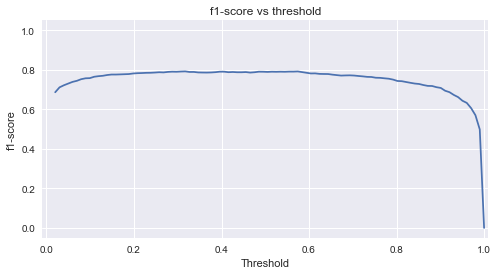

In [256]:
# f1-score vs threshold
thrslds = np.linspace(0.02, 1, num=100)
scores = pd.Series([f1_score(y_val, y_pred[:,1] > thrsld) for thrsld in thrslds])

plt.style.use('seaborn')
f, ax = plt.subplots(figsize=(8, 4));
plt.xlim([-0.01, 1.01]); 
plt.ylim([-0.05, 1.05]);
plt.xlabel('Threshold');
plt.ylabel('f1-score');
plt.title('f1-score vs threshold');
plt.plot(thrslds, scores, label='RF');
plt.grid(True);
#plt.legend(loc='best')
plt.show();

In [257]:
threshold = 0.5

# Train model on [train + val] with optimal hyperparameters

In [259]:
# create new_train
x_train = train[train.columns[:-1]]
# x_train.drop(columns = ['id', 'target', 'split'], inplace = True)
x_train.drop(columns = ['id'], inplace = True)
y_train = train[['target']]

In [261]:
cat_features = ['keyword']
clf = CatBoostClassifier(eval_metric='F1', cat_features=cat_features)
clf.fit(x_train, y_train)

Learning rate set to 0.029758
0:	learn: 0.6997869	total: 219ms	remaining: 3m 38s
1:	learn: 0.7303906	total: 299ms	remaining: 2m 28s
2:	learn: 0.7309302	total: 375ms	remaining: 2m 4s
3:	learn: 0.7371650	total: 460ms	remaining: 1m 54s
4:	learn: 0.7416423	total: 537ms	remaining: 1m 46s
5:	learn: 0.7452830	total: 615ms	remaining: 1m 41s
6:	learn: 0.7427637	total: 699ms	remaining: 1m 39s
7:	learn: 0.7414921	total: 776ms	remaining: 1m 36s
8:	learn: 0.7448546	total: 856ms	remaining: 1m 34s
9:	learn: 0.7496340	total: 941ms	remaining: 1m 33s
10:	learn: 0.7485724	total: 1.02s	remaining: 1m 31s
11:	learn: 0.7519115	total: 1.09s	remaining: 1m 30s
12:	learn: 0.7570124	total: 1.19s	remaining: 1m 30s
13:	learn: 0.7582597	total: 1.36s	remaining: 1m 35s
14:	learn: 0.7572339	total: 1.5s	remaining: 1m 38s
15:	learn: 0.7584517	total: 1.61s	remaining: 1m 39s
16:	learn: 0.7592744	total: 1.7s	remaining: 1m 38s
17:	learn: 0.7589023	total: 1.79s	remaining: 1m 37s
18:	learn: 0.7593320	total: 1.87s	remaining: 1m

157:	learn: 0.8175467	total: 13.1s	remaining: 1m 10s
158:	learn: 0.8183886	total: 13.2s	remaining: 1m 9s
159:	learn: 0.8190383	total: 13.3s	remaining: 1m 9s
160:	learn: 0.8198374	total: 13.5s	remaining: 1m 10s
161:	learn: 0.8194219	total: 13.5s	remaining: 1m 10s
162:	learn: 0.8194805	total: 13.6s	remaining: 1m 9s
163:	learn: 0.8189795	total: 13.7s	remaining: 1m 9s
164:	learn: 0.8192888	total: 13.8s	remaining: 1m 9s
165:	learn: 0.8203962	total: 13.9s	remaining: 1m 9s
166:	learn: 0.8207042	total: 13.9s	remaining: 1m 9s
167:	learn: 0.8207042	total: 14s	remaining: 1m 9s
168:	learn: 0.8209536	total: 14.1s	remaining: 1m 9s
169:	learn: 0.8220998	total: 14.2s	remaining: 1m 9s
170:	learn: 0.8214691	total: 14.3s	remaining: 1m 9s
171:	learn: 0.8219844	total: 14.4s	remaining: 1m 9s
172:	learn: 0.8226721	total: 14.5s	remaining: 1m 9s
173:	learn: 0.8226721	total: 14.6s	remaining: 1m 9s
174:	learn: 0.8224814	total: 14.7s	remaining: 1m 9s
175:	learn: 0.8225571	total: 14.7s	remaining: 1m 8s
176:	learn:

316:	learn: 0.8541465	total: 26s	remaining: 56s
317:	learn: 0.8541935	total: 26.1s	remaining: 55.9s
318:	learn: 0.8544692	total: 26.2s	remaining: 55.8s
319:	learn: 0.8545161	total: 26.2s	remaining: 55.7s
320:	learn: 0.8553906	total: 26.3s	remaining: 55.6s
321:	learn: 0.8557599	total: 26.4s	remaining: 55.5s
322:	learn: 0.8564053	total: 26.5s	remaining: 55.5s
323:	learn: 0.8562671	total: 26.5s	remaining: 55.4s
324:	learn: 0.8559445	total: 26.6s	remaining: 55.3s
325:	learn: 0.8564053	total: 26.7s	remaining: 55.2s
326:	learn: 0.8567742	total: 26.8s	remaining: 55.1s
327:	learn: 0.8568204	total: 26.8s	remaining: 55s
328:	learn: 0.8570508	total: 26.9s	remaining: 54.9s
329:	learn: 0.8576495	total: 27s	remaining: 54.8s
330:	learn: 0.8575572	total: 27.1s	remaining: 54.7s
331:	learn: 0.8575572	total: 27.1s	remaining: 54.6s
332:	learn: 0.8578337	total: 27.2s	remaining: 54.5s
333:	learn: 0.8583400	total: 27.3s	remaining: 54.4s
334:	learn: 0.8584784	total: 27.4s	remaining: 54.3s
335:	learn: 0.858984

476:	learn: 0.8974318	total: 38.5s	remaining: 42.2s
477:	learn: 0.8979592	total: 38.6s	remaining: 42.1s
478:	learn: 0.8982781	total: 38.6s	remaining: 42s
479:	learn: 0.8984213	total: 38.7s	remaining: 41.9s
480:	learn: 0.8992347	total: 38.8s	remaining: 41.9s
481:	learn: 0.8994422	total: 38.9s	remaining: 41.8s
482:	learn: 0.8994422	total: 38.9s	remaining: 41.7s
483:	learn: 0.8997610	total: 39s	remaining: 41.6s
484:	learn: 0.8995536	total: 39.1s	remaining: 41.5s
485:	learn: 0.8997290	total: 39.2s	remaining: 41.4s
486:	learn: 0.8994102	total: 39.3s	remaining: 41.3s
487:	learn: 0.8997290	total: 39.3s	remaining: 41.3s
488:	learn: 0.9000478	total: 39.4s	remaining: 41.2s
489:	learn: 0.9006221	total: 39.5s	remaining: 41.1s
490:	learn: 0.9007974	total: 39.6s	remaining: 41s
491:	learn: 0.9012602	total: 39.6s	remaining: 40.9s
492:	learn: 0.9014354	total: 39.7s	remaining: 40.8s
493:	learn: 0.9011164	total: 39.8s	remaining: 40.8s
494:	learn: 0.9015164	total: 39.9s	remaining: 40.7s
495:	learn: 0.9021

637:	learn: 0.9331235	total: 51.2s	remaining: 29.1s
638:	learn: 0.9328088	total: 51.3s	remaining: 29s
639:	learn: 0.9331025	total: 51.4s	remaining: 28.9s
640:	learn: 0.9332704	total: 51.5s	remaining: 28.8s
641:	learn: 0.9332704	total: 51.5s	remaining: 28.7s
642:	learn: 0.9335642	total: 51.6s	remaining: 28.6s
643:	learn: 0.9338999	total: 51.7s	remaining: 28.6s
644:	learn: 0.9338999	total: 51.8s	remaining: 28.5s
645:	learn: 0.9345294	total: 51.8s	remaining: 28.4s
646:	learn: 0.9346971	total: 51.9s	remaining: 28.3s
647:	learn: 0.9345294	total: 52s	remaining: 28.2s
648:	learn: 0.9354940	total: 52.1s	remaining: 28.2s
649:	learn: 0.9351794	total: 52.1s	remaining: 28.1s
650:	learn: 0.9350322	total: 52.2s	remaining: 28s
651:	learn: 0.9350322	total: 52.3s	remaining: 27.9s
652:	learn: 0.9352201	total: 52.4s	remaining: 27.8s
653:	learn: 0.9355549	total: 52.4s	remaining: 27.7s
654:	learn: 0.9357019	total: 52.5s	remaining: 27.7s
655:	learn: 0.9357019	total: 52.6s	remaining: 27.6s
656:	learn: 0.9358

799:	learn: 0.9629860	total: 1m 4s	remaining: 16.1s
800:	learn: 0.9631473	total: 1m 4s	remaining: 16s
801:	learn: 0.9629860	total: 1m 4s	remaining: 15.9s
802:	learn: 0.9633085	total: 1m 4s	remaining: 15.8s
803:	learn: 0.9636194	total: 1m 4s	remaining: 15.7s
804:	learn: 0.9637805	total: 1m 4s	remaining: 15.7s
805:	learn: 0.9637805	total: 1m 4s	remaining: 15.6s
806:	learn: 0.9637805	total: 1m 4s	remaining: 15.5s
807:	learn: 0.9641026	total: 1m 4s	remaining: 15.4s
808:	learn: 0.9642524	total: 1m 5s	remaining: 15.3s
809:	learn: 0.9643912	total: 1m 5s	remaining: 15.3s
810:	learn: 0.9643802	total: 1m 5s	remaining: 15.2s
811:	learn: 0.9650241	total: 1m 5s	remaining: 15.1s
812:	learn: 0.9650241	total: 1m 5s	remaining: 15s
813:	learn: 0.9652174	total: 1m 5s	remaining: 14.9s
814:	learn: 0.9653673	total: 1m 5s	remaining: 14.9s
815:	learn: 0.9653673	total: 1m 5s	remaining: 14.8s
816:	learn: 0.9656886	total: 1m 5s	remaining: 14.7s
817:	learn: 0.9655280	total: 1m 5s	remaining: 14.6s
818:	learn: 0.96

958:	learn: 0.9807781	total: 1m 17s	remaining: 3.29s
959:	learn: 0.9810915	total: 1m 17s	remaining: 3.21s
960:	learn: 0.9810915	total: 1m 17s	remaining: 3.13s
961:	learn: 0.9812423	total: 1m 17s	remaining: 3.05s
962:	learn: 0.9812423	total: 1m 17s	remaining: 2.97s
963:	learn: 0.9812423	total: 1m 17s	remaining: 2.89s
964:	learn: 0.9812423	total: 1m 17s	remaining: 2.81s
965:	learn: 0.9813989	total: 1m 17s	remaining: 2.73s
966:	learn: 0.9813989	total: 1m 17s	remaining: 2.65s
967:	learn: 0.9813989	total: 1m 17s	remaining: 2.57s
968:	learn: 0.9817120	total: 1m 17s	remaining: 2.49s
969:	learn: 0.9817120	total: 1m 17s	remaining: 2.41s
970:	learn: 0.9817120	total: 1m 18s	remaining: 2.33s
971:	learn: 0.9815555	total: 1m 18s	remaining: 2.25s
972:	learn: 0.9817120	total: 1m 18s	remaining: 2.17s
973:	learn: 0.9817120	total: 1m 18s	remaining: 2.09s
974:	learn: 0.9815555	total: 1m 18s	remaining: 2.01s
975:	learn: 0.9815555	total: 1m 18s	remaining: 1.93s
976:	learn: 0.9815555	total: 1m 18s	remaining:

In [262]:
# make prediction as probabilities and binarize them with optimal threshold
y_pred = clf.predict_proba(x_test)[:,1]
y_pred_binary = np.array(y_pred > threshold, dtype=np.int)

In [263]:
test['target'] = y_pred_binary

In [264]:
test[['id', 'target']].to_csv('submission.csv', index = False)